# Comparison of Transformer Models with Code dataset

Comparison of models, using a dataset of python code. The aim is to find interesting prompts where an MLP layer is required to accurately predict next tokens.


## Setup

### Imports

In [38]:
from transformers import AutoTokenizer
from IPython.display import display, clear_output
from ipywidgets import widgets
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from circuitsvis.tokens import colored_tokens
from codegen import infer
from easy_transformer import EasyTransformer
import torch
import os
from pathlib import Path

### Get code prompts (training dataset)

In [ ]:
# Load code dataset
prompts_dataset = load_dataset("NeelNanda/code-tokenized", split="train")

# Convert into a nested list [prompts x tokens]
prompts_tokens: List[List[int]] = []
for prompt_tokens in tqdm(prompts_dataset):
    prompts_tokens.append(prompt_tokens["tokens"])

# Convert into a NumPy array
prompts_tokens = np.array(prompts_tokens)
prompts_tokens.shape

### Model names

In [19]:
model_names = os.listdir("data/full_pred_log_probs/code/")
model_names.sort()
model_names

['attn-only-1l',
 'attn-only-2l',
 'attn-only-3l',
 'attn-only-4l',
 'gelu-1l',
 'gelu-2l',
 'gelu-3l',
 'gelu-4l',
 'solu-1l',
 'solu-2l',
 'solu-3l',
 'solu-4l']

## Model accuracy comparison

In [37]:

# Output
out = widgets.Output()

def plot_hist_diff_by_prompt(model_1_name: str, model_2_name: str, log_prob: bool = True) -> None:
    #  Get the log probs
    version = "v1"
    code_directory = Path("data" / "full_pred_log_probs" / "code")
    model_1_data = torch.load(
        code_directory / model_1_name / version / "pred_log_probs.pth"
        ).to("cpu").invert()
    model_2_data = torch.load(
        code_directory / model_2_name / version / "pred_log_probs.pth"
        ).to("cpu").invert()
    
    # Get the differences
    log_prob_diff = model_1_data - model_2_data
    
    # Create histogram
    diff_np = log_prob_diff.numpy()
    prob_diff_by_prompt = np.mean(diff_np, axis=-1)
    plt.hist(prob_diff_by_prompt, bins=100)
    plt.title(f"Mean log prob difference between {model_2_name} and {model_1_name}")
    
    # Show histogram
    with out:
        plt.show()
    
# Create dropdowns
default_1 = model_names[0]
model_1_selector = widgets.Dropdown(
    options=model_names,
    description='Model 1',
    value=default_1
)

default_2 = model_names[1]
model_2_selector = widgets.Dropdown(
    options=model_names,
    description='Model 2',
    value=default_2
)

# default
with out:
    plot_hist_diff_by_prompt(default_1, default_2)

# Handle changes
def on_change(change):
    if change["type"] == "change" and change["name"] == "value":
        with out:
            clear_output()
            plot_hist_diff_by_prompt(model_1_selector.value, model_2_selector.value)

model_1_selector.observe(on_change)
model_2_selector.observe(on_change)

display(model_1_selector, model_2_selector, out)

Dropdown(description='Model 1', options=('attn-only-1l', 'attn-only-2l', 'attn-only-3l', 'attn-only-4l', 'gelu…

Dropdown(description='Model 2', index=1, options=('attn-only-1l', 'attn-only-2l', 'attn-only-3l', 'attn-only-4…

Output()

## Model comparison aggregate results

In [5]:
# Get the difference in performance between models
prob_diff = np.exp(results["NeelNanda/SoLU_1L512W_C4_Code"]) \
    - np.exp(results["NeelNanda/Attn_Only_1L512W_C4_Code"])

prob_diff.shape

(297257, 1023)

### Histogram of differences by token

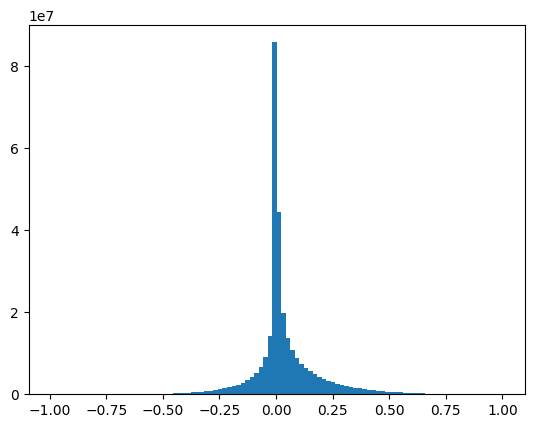

In [6]:
prob_diff_flat: np.ndarray = prob_diff.flatten()
plt.hist(prob_diff_flat, bins=100)
plt.show()

### Histogram of differences by prompt

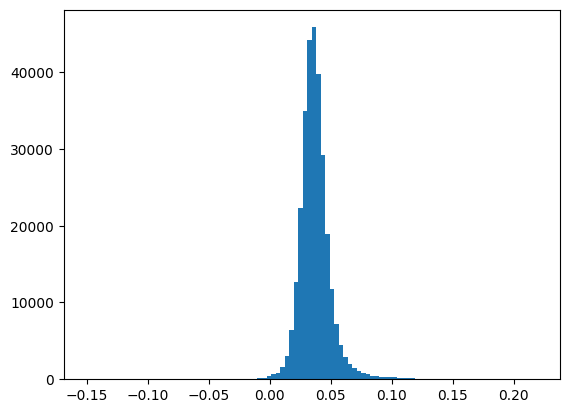

In [7]:
prob_diff_by_prompt = np.mean(prob_diff, axis=-1)
plt.hist(prob_diff_by_prompt, bins=100)
plt.show()

## Prompts that are most impacted by adding MLP layers

### Histogram

array([[<AxesSubplot: title={'center': 'count_significant'}>]],
      dtype=object)

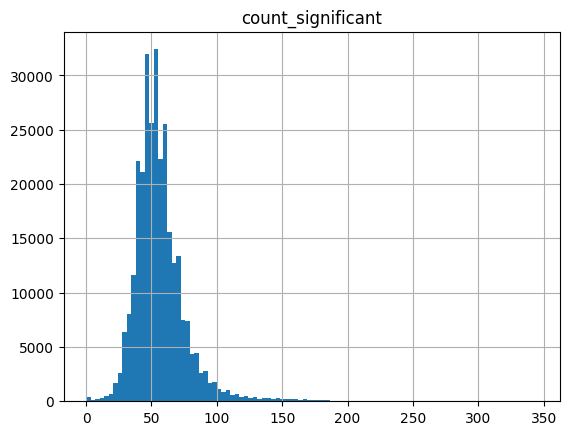

In [8]:
# Rank the prompts by number of tokens that are significantly better with the
# MLP layer
threshold = 0.3
count_prob_diff_above_threshold = np.sum(prob_diff > threshold, axis=-1)
ranked_prompts = pd.DataFrame({"count_significant": count_prob_diff_above_threshold})
ranked_prompts.sort_values(by="count_significant", ascending=False, inplace=True)
prompt_ids_ranked = ranked_prompts.index.values

# Show histogram for the number of tokens that are significantly better, per prompt
ranked_prompts.hist(bins=100)

### Dropdown to view prob diff by token, for different prompts

In [91]:
def show_prob_diff_colored_tokens(prompt_id: int) -> None:
    prompt_token_diff = prob_diff[prompt_id, :]
    
    tokenizer = AutoTokenizer.from_pretrained("NeelNanda/gpt-neox-tokenizer-digits")
    token_strings = [tokenizer.decode(t) for t in prompts_tokens[prompt_id]][0:-1]
    
    return colored_tokens(
        values=prompt_token_diff.tolist(),
        tokens=token_strings,
        min_value=-1,
        max_value=1,
    )
    
model_1_selector = widgets.Dropdown(
    options=[ (f"{ind}: Prompt {prompt_id}", prompt_id) for ind, prompt_id in  enumerate(prompt_ids_ranked[0:500])],
    description='Prompt ID',
)

out = widgets.Output()
with out:
    display(show_prob_diff_colored_tokens(prompt_ids_ranked[0]))

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with out:
            clear_output()
            display(f"Number above threshold: {count_prob_diff_above_threshold[change['new']]}")
            display(show_prob_diff_colored_tokens(change['new']))


model_1_selector.observe(on_change)

display(model_1_selector, out)

Dropdown(description='Prompt ID', options=(('0: Prompt 139682', 139682), ('1: Prompt 247267', 247267), ('2: Pr…

Output()

### Top prompts

In [75]:
# Show top prompts
top_prompts = prompt_ids_ranked[0:1000]
tokenizer = AutoTokenizer.from_pretrained("NeelNanda/gpt-neox-tokenizer-digits")
top_100_prompts = [tokenizer.decode(p) for p in prompts_tokens[top_prompts]]
pd.set_option('display.max_rows', 500)
pd.DataFrame({"prompt": top_100_prompts}).head(200)


,prompt
0,<|BOS|>0000000000' #...\n '0000000000000000...
1,<|BOS|> # # # # # 0 #\n# 0 # 0 0 0 0 0 # 0 0 0...
2,<|BOS|>EXPR_SUB_ASSIGN = enum.auto()\n\tEXPR_D...
3,"<|BOS|>,0.000,0.000,0.000,0.000,0.000,0.000],\..."
4,"<|BOS|>.000,0.000,0.000,0.000,0.000,0.000,0.00..."
5,"<|BOS|>,0.000,0.000,0.000,0.000,0.000,0.000],\..."
6,"<|BOS|>0.000,0.000,0.000,0.000,0.000,0.000,0.0..."
7,"<|BOS|>,0.000,0.000,0.000,0.000,0.000,0.000,0...."
8,"<|BOS|>0,0.000,0.000,0.000,0.000,0.000,0.000],..."
9,"<|BOS|>5,0.000,0.000,0.000,0.000,0.000,0.000,0..."


### Things copied



- `VAR_NAME = ` -> `enum`
- Comma at end of list item (2)
- Single quote comma at end of list item (4) `',` or `'`
- `),` and `'),` at end of each list item (2)
- u at start of unicode string (in list) e.g. `u'\U0001d677': ... `
- Double space after comma in list (2) (also 5 space after close brackets `)`) (7)
- Long list of `Text = Text.replace(....` (second `Text`)
- New line repeated sequence of var names (`SC_...`)
- `()` in repeated `f()` 
- Weird random repeated sequences e.g. end of `TSS_TSPATTRIB` and
  `IVISCOPE_ATTR` and ` RPL_` (3) and `IV` and ` (Token` at beginning of each
  new line (2)
- Permutations of copied tokens (eg. 165)

### Examples

#### Setup

In [143]:
tokenizer = AutoTokenizer.from_pretrained("NeelNanda/gpt-neox-tokenizer-digits")
attn = EasyTransformer.from_pretrained("NeelNanda/Attn_Only_1L512W_C4_Code")
solu = EasyTransformer.from_pretrained("NeelNanda/SoLU_1L512W_C4_Code")
clear_output()

In [193]:
def show_prompt_comparison(prompt: str):
    prompt_batch = torch.tensor(tokenizer.encode(prompt), device="cuda").unsqueeze(0)

    token_strings = [tokenizer.decode(t) for t in tokenizer.encode(prompt)]

    attn_log_probs = infer.run_batch(attn, prompt_batch).squeeze(0)
    solu_log_probs = infer.run_batch(solu, prompt_batch).squeeze(0)
    print(attn_log_probs.shape)

    diff = np.exp(solu_log_probs.detach().cpu().numpy()) - np.exp(attn_log_probs.detach().cpu().numpy())

    tokens = colored_tokens(
        values=diff.tolist(),
        tokens=token_strings,
        # min_value=-1,
        # max_value=1,
    )

    display(tokens)

#### Lists (new lines)

Note spaces after the new line are confusingly tokenized with the newline
character.

Based on 163 (129820)

In [203]:
# Short list
prompt = """my_arr = [
    'DDR4 SDRAM',
    'Medal of Honor: Frontline',
    'Sisters of War',
]"""

show_prompt_comparison(prompt)

torch.Size([32])


In [196]:
# List of strings
prompt = """my_arr = [
    'DDR4 SDRAM',
    'Medal of Honor: Frontline',
    'Sisters of War',
    'Batalla de Monte Tumbledown',
    'Gypsy Heart Tour',
    'Monster in My Pocket',
    'El problema del costo social',
    'Dōjutsu',
    'Elizabeth Eichhorn',
    'Plataforma HD',
    'Jeremy Scahill',
    'Caxuxi',
    'Marbella Corella',
    'Boris Kodjoe',
    'Carol Cleveland',
    'Joseph Morgan',
    'Aidan Alexander',
    'Sentispac',
]"""

show_prompt_comparison(prompt)

torch.Size([144])


In [200]:
# List of numbers
prompt = """my_arr = [
    0.128123,
    0.457345,
    0.231342,
    0.234234,
    0.123671,
    0.128123,
    0.457345,
    0.231342,
    0.234234,
    0.123671,
    0.128123,
    0.457345,
    0.231342,
    0.234234,
    0.123671,
]"""

show_prompt_comparison(prompt)

torch.Size([156])


In [201]:
# List without indent
prompt = """my_arr = [
'DDR4 SDRAM',
'Medal of Honor: Frontline',
'Sisters of War',
'Batalla de Monte Tumbledown',
'Gypsy Heart Tour',
'Monster in My Pocket',
'El problema del costo social',
'Dōjutsu',
'Elizabeth Eichhorn',
'Plataforma HD',
'Jeremy Scahill',
'Caxuxi',
'Marbella Corella',
'Boris Kodjoe',
'Carol Cleveland',
'Joseph Morgan',
'Aidan Alexander',
'Sentispac',
]"""

show_prompt_comparison(prompt)

torch.Size([144])


In [202]:
# Mashed text middle
prompt = """my_arr = [
    'DDR4 SDRAM',
    'Medal of Honor: Frontline',
    'Sisters of War',
    'Batalla de Monte Tumbledown',
    'Gypsy Heart Tour',
    'Monster in My Pocket',
  jsahdfkahskdfjhaksjfhd jkash dfjb vas dfja sdhfas fioah
  
  ashdfhas d
  asiodfjo]apsdf[ as
  df]
    'Caxuxi',
    'Marbella Corella',
    'Boris Kodjoe',
    'Carol Cleveland',
    'Joseph Morgan',
    'Aidan Alexander',
    'Sentispac',
]"""

show_prompt_comparison(prompt)

torch.Size([149])


#### . properties (182)

In [219]:
# Base
prompt = """        .hexcodes[0xA6] = ("ldx", "zeropage")
        self.hexcodes[0xB6] = ("ldx", "zeropagey")
        .hexcodes[0xC6] = ("dec", "zeropage")
        .hexcodes[0xD6] = ("dec", "zeropagex")
        .hexcodes[0xE6] = ("inc", "zeropage")
        self.hexcodes[0xF6] = ("inc", "zeropagex")
        self.hexcodes[0x07] = ("", "")
        self.hexcodes[0x17] = ("", "")
        self.hexcodes[0x27] = ("", "")
        self.hexcodes[0x37] = ("", "")
        self.hexcodes[0x47] = ("", "")
        self.hexcodes[0x57] = ("", "")
        self.hexcodes[0x67] = ("", "")
        self.hexcodes[0x07] = ("", "")
        self.hexcodes[0x17] = ("", "")"""
 
show_prompt_comparison(prompt)

torch.Size([268])


In [220]:
# Mashed middle
prompt = prompt = """        self.hexcodes[0xA6] = ("ldx", "zeropage")
        self.hexcodes[0xB6] = ("ldx", "zeropagey")
        self.hexcodes[0xC6] = ("dec", "zeropage")
        self.hexcodes[0xD6] = ("dec", "zeropagex")
        self.hexcodes[0xE6] = ("inc", "zeropage")
        self.hexcodes[0xF6] = ("inc", "zeropagex")

        sdafasdf as dfas asfd as df
        asdfsa dfas df
        
        self.hexcodes[0x47] = ("", "")
        self.hexcodes[0x57] = ("", "")
        self.hexcodes[0x67] = ("", "")
        self.hexcodes[0x07] = ("", "")
        self.hexcodes[0x17] = ("", "")"""
 
show_prompt_comparison(prompt)

torch.Size([225])


In [221]:
# Different method
prompt = prompt = """        self.codes[0xA6] = ("ldx", "zeropage")
        self.codes[0xB6] = ("ldx", "zeropagey")
        self.codes[0xC6] = ("dec", "zeropage")
        self.codes[0xD6] = ("dec", "zeropagex")
        self.codes[0xE6] = ("inc", "zeropage")
        self.codes[0xF6] = ("inc", "zeropagex")
        self.codes[0x47] = ("", "")
        self.codes[0x57] = ("", "")
        self.codes[0x67] = ("", "")
        self.codes[0x07] = ("", "")
        self.codes[0x17] = ("", "")"""
 
show_prompt_comparison(prompt)

torch.Size([182])


In [222]:
# Without self
prompt = """        .hexcodes[0xA6] = ("ldx", "zeropage")
        .hexcodes[0xB6] = ("ldx", "zeropagey")
        .hexcodes[0xC6] = ("dec", "zeropage")
        .hexcodes[0xD6] = ("dec", "zeropagex")
        .hexcodes[0xE6] = ("inc", "zeropage")
        .hexcodes[0xF6] = ("inc", "zeropagex")
        .hexcodes[0x07] = ("", "")
        .hexcodes[0x17] = ("", "")
        .hexcodes[0x27] = ("", "")"""
 
show_prompt_comparison(prompt)

torch.Size([163])


- 